# Boat trip Data analysis

First we fetch the data from github.
By running the following command the data will be coppied in the cloud server where you are running this notebook, so you could access it :)

 You can also access the data in [here](https://github.com/franamor98/MIR_BOAT_DAY1_DATA.git)

In [38]:
!git clone https://github.com/AyeshaAslam1/MIR_BOAT_DAY1_DATA.git

fatal: destination path 'MIR_BOAT_DAY1_DATA' already exists and is not an empty directory.


Now we are going to install some packages and import the modules used!

In [39]:
!pip install folium
!pip install geopy
!pip install ctd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import pandas as pd
import numpy as np
import os 
from datetime import datetime as dt
from datetime import timedelta
from geopy.distance import geodesic
import folium
from folium import plugins
from sklearn.preprocessing import MinMaxScaler

#for CTD
import ctd
import matplotlib.pyplot as plt


## Drifters Analysis

In [41]:
#Since its in csv format we can read it using the pandas module!
logSheet = pd.read_csv(f'./MIR_BOAT_DAY1_DATA/MIROceanographyAnalysis/logsheet_Day2.csv',encoding='utf8', nrows=9) 

#Next we apply to transformation to the data:
#Remove the id number extra digits, to get only the last 3 digits od the id, it is what we are using
logSheet['Id'] = logSheet['Id'].apply(lambda x: x[-3:])
#We want to convert the time as string to a datetime timestamp for both recover and deploy
logSheet['Deployment'] = [
    dt.strptime(f'{logSheet.iloc[i]["Deployment"]}:00', '%H:%M:%S') - timedelta(hours=2, minutes=0)
    for i in range(len(logSheet))
]

logSheet['Recovery'] = [
    dt.strptime(f'{logSheet.iloc[i]["Recovery"]}:00', '%H:%M:%S') - timedelta(hours=2, minutes=0)
    for i in range(len(logSheet))
]

#Now we can take a look at it
logSheet

,Station,Type,Id,Deployment,Lon,Lat,Recovery,Lon.1,Lat.1
0,1,\tYellow 1m,274,1900-01-01 07:47:00,5º 58.363',43º 4.655',1900-01-01 10:40:00,5º 57.564',43º 4.783'
1,1,White surface,436,1900-01-01 07:47:00,5º 58.363',43º 4.655',1900-01-01 10:32:00,5º 57.185',43º 4.708'
2,1,White 60cm,439,1900-01-01 07:47:00,5º 58.363',43º 4.655',1900-01-01 10:42:00,5º 57.571',43º 4.803'
3,2,\tYellow 1m,273,1900-01-01 07:59:00,5º 59.055',43º 4.723',1900-01-01 12:03:00,5º 57.743',43º 5.145'
4,2,White 60cm,230,1900-01-01 07:59:00,5º 59.055',43º 4.723',1900-01-01 11:59:00,5º 57.955',43º 5.144'
5,2,White surface,119,1900-01-01 07:59:00,5º 59.055',43º 4.723',1900-01-01 12:12:00,5º 56.777',43º 5.185'
6,3,\tYellow 1m,277,1900-01-01 08:16:00,5º 59.956',43º 4.809',1900-01-01 11:45:00,5º 58.864',43º 5.309'
7,3,White surface,052,1900-01-01 08:16:00,5º 59.956',43º 4.809',1900-01-01 11:52:00,5º 58.161',43º 5.361'
8,3,White 60cm,368,1900-01-01 08:16:00,5º 59.956',43º 4.809',1900-01-01 11:43:00,5º 59.034',43º 5.274'


### We are are ready to load our trip data from the log sheet

## Merge all drifters in a single DataFrame

In [42]:
drifter_folder = "./MIR_BOAT_DAY1_DATA/MIROceanographyAnalysis/DriftersData/"
#First we read the white drifter data from the single csv containing all of them
df_all = pd.read_csv(f'{drifter_folder}Day_2_Driffters_Merged.csv',encoding='utf8')
df_all




,DeviceName,DeviceDateTime,BatteryStatus,CommId,Latitude,Longitude
0,0-4407230,12/10/2022 12:04:00,LOW,0-4407230,43.08582,5.96225
1,0-4407230,12/10/2022 11:59:00,LOW,0-4407230,43.08512,5.96628
2,0-4407230,12/10/2022 11:54:00,LOW,0-4407230,43.08493,5.96669
3,0-4407230,12/10/2022 11:49:00,LOW,0-4407230,43.08470,5.96721
4,0-4407230,12/10/2022 11:44:00,LOW,0-4407230,43.08452,5.96770
...,...,...,...,...,...,...
308,0-4406439,12/10/2022 7:29:00,GOOD,0-4406439,43.08781,5.92457
309,0-4406439,12/10/2022 7:24:00,GOOD,0-4406439,43.09728,5.91841
310,0-4406439,12/10/2022 7:19:00,GOOD,0-4406439,43.10380,5.90828
311,0-4406439,12/10/2022 7:14:00,GOOD,0-4406439,43.10555,5.89472


In [43]:
#We remove the data we are not goin to use
df_all = df_all.drop(['BatteryStatus','CommId'], axis=1)
#We remove erroneous data
df_all = df_all.dropna()

#We iterate over the data folder and we only get the yellow drifters files (txt files)
for file in [i for i in os.listdir(drifter_folder) if i[-3:]=='txt']:
    #We get the id
    drifter_id = f'{file.split(".")[-2][-3:]}'#split filename by ".", get the second last, and get 3 last characters
    print(file)
    #read the csv, yes its a csv even if its termination its txt
    df = pd.read_csv(f'{drifter_folder}{file}',encoding='utf8')
    #We rename the time column like the white data is
    df = df.rename(columns={"Reception time (UTC)": "DeviceDateTime"})
    #create a new colunm with the id
    df['DeviceName'] = drifter_id
    #We remove the data we are not goin to use
    df = df.drop(['Position time (UTC)', 'Course','Speed (m/s)','Status','Battery','Temperature'], axis=1)
    #order the columns like the white ones
    df = df.loc[:, ["DeviceName","DeviceDateTime","Latitude","Longitude"]]
    #Append what we have to the big dataframe
    df_all = df_all.append(df)
    

LCI00277.txt
LCI00274.txt
LCI00273.txt


## Now we can apply the same processing for all of them
Please always execute the cell above before this step

In [44]:
pd.options.mode.chained_assignment = None  
#we create some dicts to store the clean data sorted by its type
yellow_drifters_df = {}
white_drifters_surface_df = {}
white_drifters_60_df = {}


#Cast date string to python datetime only 'caring' about the hours
df_all['DeviceDateTime'] = df_all['DeviceDateTime'].apply(lambda x: dt.strptime(x.split()[-1], '%H:%M:%S')) 
#Remove the id number extra digits, to get only the last 3 digits od the id, it is what we are using
df_all['DeviceName'] = df_all['DeviceName'].apply(lambda x: x[-3:])

#Sort the DataFrame by the time and reset the index
df_all=df_all.sort_values(by='DeviceDateTime').reset_index()

In [45]:
df_all

,index,DeviceName,DeviceDateTime,Latitude,Longitude
0,102,436,1900-01-01 07:06:00,43.10528,5.88562
1,152,119,1900-01-01 07:07:00,43.10520,5.88573
2,269,368,1900-01-01 07:08:00,43.10501,5.88498
3,312,439,1900-01-01 07:09:00,43.10432,5.88638
4,59,230,1900-01-01 07:10:00,43.10444,5.88644
...,...,...,...,...,...
384,153,052,1900-01-01 11:58:00,43.08428,5.96721
385,1,230,1900-01-01 11:59:00,43.08512,5.96628
386,28,273,1900-01-01 12:00:16,43.08536,5.96300
387,212,368,1900-01-01 12:02:00,43.08416,5.96448


In [46]:
#We iterate over the logSheet entries
for index, row in logSheet.iterrows():
  
    #Filter the df to get only the signal after deployment and before recover
    df = df_all.loc[
        (df_all['DeviceName'] ==  row['Id']) # Id that we want
        & #and
        (df_all['DeviceDateTime'] > row['Deployment']) # DeviceDateTime is greater than deploy
        & #and
        (df_all['DeviceDateTime'] < row['Recovery']) # DeviceDateTime is smaller than recover
    ]
    
    #We make sure that there is some data
    if len(df)>0:
        
        #We compute the geodesic distance using geopy function, for all the values of this drifter
        #The new column we are creating its going to be filled with the array defined in the for loop
        df['distance'] = [ 
            #compute the distance
            geodesic(
                [df.iloc[i-1]['Latitude'],df.iloc[i-1]['Longitude']], #pos i-1
                [df.iloc[i]['Latitude'],df.iloc[i]['Longitude']] #pos i
            ).m
            if i>0 #not for the first element to avoid erros
            else np.finfo(float).eps #instead we fill it with an infinitesimal value to avoid dividing by 0
            for i in range(len(df)) #for i position such as i is the number of elements
        ]
        #compute the time delta
        df['time_delta'] = [ 
            #by resting time(i-1) and time(i) and gettings the seconds of it
            np.abs((df.iloc[i-1]['DeviceDateTime']-df.iloc[i]['DeviceDateTime']).total_seconds())
            if i>0
            else 1
            for i in range(len(df))
        ]
        #The velocity will be de  division of this values
        df['velocity'] = df['distance']/df['time_delta']
        
        # apply normalization techniques for velocity visualization
        df['vel_normalized'] = MinMaxScaler().fit_transform(np.array(df['velocity']).reshape(-1,1))
        #Depending of its type we put it in a place or another
        if "60" in row['Type']:
            white_drifters_60_df[row['Id']]=df
        elif 'surface' in row['Type']:
            white_drifters_surface_df[row['Id']]=df
        elif '1m' in row['Type']:
            yellow_drifters_df[row['Id']]=df


In [47]:
#We create a map object using folium
m = folium.Map(location=[43.05228, 5.94], zoom_start=12, tiles="Stamen Terrain")
#We add a raster layer using a wms service from emodnet thats provide bathymetry maps
folium.raster_layers.WmsTileLayer(url= 'https://ows.emodnet-bathymetry.eu/wms',
                                  layers = 'mean_rainbowcolour',
                                  opacity = 0.3,
                                  transparent = True, 
                                  control = True,
                                  fmt="image/png",
                                  name = 'bathymetry',
                                  overlay = True,
                                  show = True,
                                  ).add_to(m)
#add this last layer to the control
folium.LayerControl().add_to(m)

#for every tyoe of drifter we plot the trayectories
for key,item in white_drifters_60_df.items():
    
    #get some variables
    lats = item['Latitude'].tolist()
    lons = item['Longitude'].tolist()
    vels = item['velocity'].tolist()
    vels_normalized = item['vel_normalized'].tolist()

    #this next lines are to make the path animated, I think its a bit ugly
    #latslons = zip(lats,lons)
    #plugins.AntPath(latslons,color='white').add_to(m)
    
    #for every point
    for i in range(len(item['Latitude'].tolist())):
    #white w drouge

        
        #plot a marker whit a poppup and its intensity proportional to its velocity
        folium.CircleMarker(
            [lats[i],lons[i] ],
            opacity = 2*vels_normalized[i],
            radius=2,color='white',
            fill_color='black',
            popup=folium.Popup(f"z=0.6m: {round(vels[i],3)}m/s")
        ).add_to(m)


for key,item in white_drifters_surface_df.items():
    #white w/o drouge
    
    lats = item['Latitude'].tolist()
    lons = item['Longitude'].tolist()
    vels = item['velocity'].tolist()
    vels_normalized = item['vel_normalized'].tolist()

    
    #latslons = zip(lats,lons)
    #plugins.AntPath(latslons,color='#8da6c2').add_to(m)
    
    for i in range(len(item['Latitude'].tolist())):
    


        folium.CircleMarker(
            [lats[i],lons[i] ],
            opacity = 2*vels_normalized[i],
            radius=2,
            color= '#785ebf',
            fill_color='white',
            popup=folium.Popup(f"z=0m: {round(vels[i],3)}m/s")
        ).add_to(m)


for key,item in yellow_drifters_df.items():
    
    lats = item['Latitude'].tolist()
    lons = item['Longitude'].tolist()
    vels = item['velocity'].tolist()
    vels_normalized = item['vel_normalized'].tolist()
    
    #latslons = zip(lats,lons)
    #plugins.AntPath(latslons,color='yellow').add_to(m)

    for i in range(len(item['Latitude'].tolist())):
       #yellow
    
        folium.CircleMarker(
            [lats[i],lons[i]],
            opacity = 2*vels_normalized[i],
            radius=2,
            color='#decb40',
            fill_color='yellow',
            popup=folium.Popup(f"z=1m: {round(vels[i],3)}m/s")
        ).add_to(m)
        
title = 'Drifter trayectories, intesities are proportional to velocities'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title)   


m.get_root().html.add_child(folium.Element(title_html))

m

In [48]:
# Initialize variables to store mean velocities
mean_velocity_white_drifters_60_df = 0
mean_velocity_white_drifters_surface_df = 0
mean_velocity_yellow_drifters_df = 0

# Calculate mean velocity for white_drifters_60_df
for key, df in white_drifters_60_df.items():
    mean_velocity_white_drifters_60_df += df['velocity'][1:].mean()
mean_velocity_white_drifters_60_df /= len(white_drifters_60_df)

# Calculate mean velocity for white_drifters_surface_df
for key, df in white_drifters_surface_df.items():
    mean_velocity_white_drifters_surface_df += df['velocity'][1:].mean()
mean_velocity_white_drifters_surface_df /= len(white_drifters_surface_df)

# Calculate mean velocity for yellow_drifters_df
for key, df in yellow_drifters_df.items():
    mean_velocity_yellow_drifters_df += df['velocity'][1:].mean()
mean_velocity_yellow_drifters_df /= len(yellow_drifters_df)


In [49]:
# Print mean velocities
print("Mean velocity for white_drifters_60_df:", mean_velocity_white_drifters_60_df)
print("Mean velocity for white_drifters_surface_df:", mean_velocity_white_drifters_surface_df)
print("Mean velocity for yellow_drifters_df:", mean_velocity_yellow_drifters_df)


Mean velocity for white_drifters_60_df: 0.12019866407390918
Mean velocity for white_drifters_surface_df: 0.19645280393218312
Mean velocity for yellow_drifters_df: 0.12880456492958994


In [50]:
#nitialize variables to store average velocities
average_velocity_white_drifters_60_df = 0
average_velocity_white_drifters_surface_df = 0
average_velocity_yellow_drifters_df = 0

#Calculate average velocity for white_drifters_60_df
for key, df in white_drifters_60_df.items():
    average_velocity_white_drifters_60_df += df['velocity'][1:].mean()
    average_velocity_white_drifters_60_df /= len(white_drifters_60_df)

#Calculate average velocity for white_drifters_surface_df
for key, df in white_drifters_surface_df.items():
    average_velocity_white_drifters_surface_df += df['velocity'][1:].mean()
    average_velocity_white_drifters_surface_df /= len(white_drifters_surface_df)

#Calculate average velocity for yellow_drifters_df
for key, df in yellow_drifters_df.items():
    average_velocity_yellow_drifters_df += df['velocity'][1:].mean()
    average_velocity_yellow_drifters_df /= len(yellow_drifters_df)

#Print average velocities
print("Average velocity for white_drifters_60_df:", average_velocity_white_drifters_60_df)
print("Average velocity for white_drifters_surface_df:", average_velocity_white_drifters_surface_df)
print("Average velocity for yellow_drifters_df:", average_velocity_yellow_drifters_df)

Average velocity for white_drifters_60_df: 0.060232322101082834
Average velocity for white_drifters_surface_df: 0.10059934233836752
Average velocity for yellow_drifters_df: 0.06733342368564975


0.2138050840674474
0.33986049101469445
0.18525008252184577


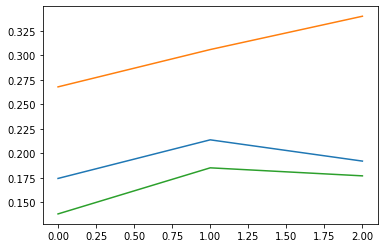

In [51]:
import matplotlib.pyplot as plt

# Initialize variables to store mean, min, and max velocities
mean_velocity_white_drifters_60_df = []
min_velocity_white_drifters_60_df = []
max_velocity_white_drifters_60_df = []
mean_velocity_white_drifters_surface_df = []
min_velocity_white_drifters_surface_df = []
max_velocity_white_drifters_surface_df = []
mean_velocity_yellow_drifters_df = []
min_velocity_yellow_drifters_df = []
max_velocity_yellow_drifters_df = []

# Calculate mean, min, and max velocities for white_drifters_60_df
for key, df in white_drifters_60_df.items():
    mean_velocity_white_drifters_60_df.append(df['velocity'].mean())
    min_velocity_white_drifters_60_df.append(df['velocity'].min())
    max_velocity_white_drifters_60_df.append(df['velocity'].max())

# Calculate mean, min, and max velocities for white_drifters_surface_df
for key, df in white_drifters_surface_df.items():
    mean_velocity_white_drifters_surface_df.append(df['velocity'].mean())
    min_velocity_white_drifters_surface_df.append(df['velocity'].min())
    max_velocity_white_drifters_surface_df.append(df['velocity'].max())

# Calculate mean, min, and max velocities for yellow_drifters_df
for key, df in yellow_drifters_df.items():
    mean_velocity_yellow_drifters_df.append(df['velocity'].mean())
    min_velocity_yellow_drifters_df.append(df['velocity'].min())
    max_velocity_yellow_drifters_df.append(df['velocity'].max())

# # Plot the mean, min, and max velocities for each dictionary
# plt.plot(mean_velocity_white_drifters_60_df, label="Mean velocity (white_drifters_60_df)")
# plt.plot(min_velocity_white_drifters_60_df, label="Minimum velocity (white_drifters_60_df)")
plt.plot(max_velocity_white_drifters_60_df, label="Maximum velocity (white_drifters_60_df)")
# plt.plot(mean_velocity_white_drifters_surface_df, label="Mean velocity (white_drifters_surface_df)")
# plt.plot(min_velocity_white_drifters_surface_df, label="Minimum velocity (white_drifters_surface_df)")
plt.plot(max_velocity_white_drifters_surface_df, label="Maximum velocity (white_drifters_surface_df)")
plt.plot(max_velocity_yellow_drifters_df, label="Maximum velocity (white_drifters_surface_df)")
print(max(max_velocity_white_drifters_60_df))
print(max(max_velocity_white_drifters_surface_df))
print(max(max_velocity_yellow_drifters_df))


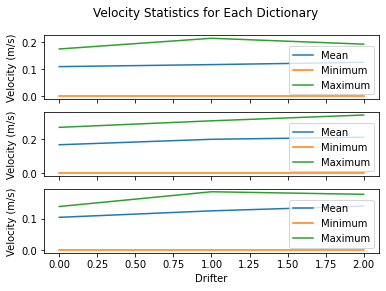

In [52]:
import matplotlib.pyplot as plt

# Initialize variables to store mean, min, and max velocities
mean_velocity_white_drifters_60_df = []
min_velocity_white_drifters_60_df = []
max_velocity_white_drifters_60_df = []
mean_velocity_white_drifters_surface_df = []
min_velocity_white_drifters_surface_df = []
max_velocity_white_drifters_surface_df = []
mean_velocity_yellow_drifters_df = []
min_velocity_yellow_drifters_df = []
max_velocity_yellow_drifters_df = []

# Calculate mean, min, and max velocities for white_drifters_60_df
for key, df in white_drifters_60_df.items():
    mean_velocity_white_drifters_60_df.append(df['velocity'].mean())
    min_velocity_white_drifters_60_df.append(df['velocity'].min())
    max_velocity_white_drifters_60_df.append(df['velocity'].max())

# Calculate mean, min, and max velocities for white_drifters_surface_df
for key, df in white_drifters_surface_df.items():
    mean_velocity_white_drifters_surface_df.append(df['velocity'].mean())
    min_velocity_white_drifters_surface_df.append(df['velocity'].min())
    max_velocity_white_drifters_surface_df.append(df['velocity'].max())

# Calculate mean, min, and max velocities for yellow_drifters_df
for key, df in yellow_drifters_df.items():
    mean_velocity_yellow_drifters_df.append(df['velocity'].mean())
    min_velocity_yellow_drifters_df.append(df['velocity'].min())
    max_velocity_yellow_drifters_df.append(df['velocity'].max())

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

# Set title and labels for the figure
fig.suptitle("Velocity Statistics for Each Dictionary")
ax1.set_ylabel("Velocity (m/s)")
ax2.set_ylabel("Velocity (m/s)")
ax3.set_ylabel("Velocity (m/s)")
ax3.set_xlabel("Drifter")
# Plot the mean, min, and max velocities for white_drifters_60_df
ax1.plot(mean_velocity_white_drifters_60_df, label="Mean")
ax1.plot(min_velocity_white_drifters_60_df, label="Minimum")
ax1.plot(max_velocity_white_drifters_60_df, label="Maximum")

# Plot the mean, min, and max velocities for white_drifters_surface_df
ax2.plot(mean_velocity_white_drifters_surface_df, label="Mean")
ax2.plot(min_velocity_white_drifters_surface_df, label="Minimum")
ax2.plot(max_velocity_white_drifters_surface_df, label="Maximum")

# Plot the mean, min, and max velocities for yellow_drifters_df
ax3.plot(mean_velocity_yellow_drifters_df, label="Mean")
ax3.plot(min_velocity_yellow_drifters_df, label="Minimum")
ax3.plot(max_velocity_yellow_drifters_df, label="Maximum")

# Add a legend to each subplot
ax1.legend()
ax2.legend()
ax3.legend()

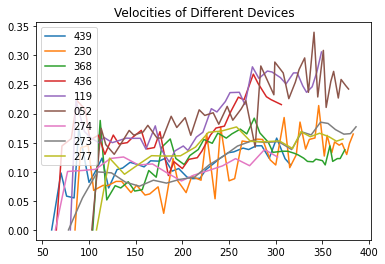

In [53]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate through each dataset and plot the velocities
for key, df in white_drifters_60_df.items():
    ax.plot(df['velocity'], label=key)
for key, df in white_drifters_surface_df.items():
    ax.plot(df['velocity'], label=key)
for key, df in yellow_drifters_df.items():
    ax.plot(df['velocity'], label=key)

# Add a legend and title to the plot
ax.legend()
ax.set_title('Velocities of Different Devices')

# Show the plot
plt.show()


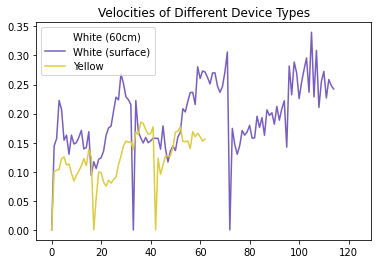

In [54]:
import matplotlib.pyplot as plt

# Create a figure and axis object with subplots
fig, ax = plt.subplots()

# Initialize lists to store velocities for each type of device
white_60_velocities = []
white_surface_velocities = []
yellow_velocities = []

# Extract velocities for each device type and store in the respective list
for key, df in white_drifters_60_df.items():
    white_60_velocities.extend(df['velocity'])
for key, df in white_drifters_surface_df.items():
    white_surface_velocities.extend(df['velocity'])
for key, df in yellow_drifters_df.items():
    yellow_velocities.extend(df['velocity'])

# Plot the velocities for each device type using different colors for each type
ax.plot(white_60_velocities, color='white', label='White (60cm)')
ax.plot(white_surface_velocities, color='#785ebf', label='White (surface)')
ax.plot(yellow_velocities, color='#decb40', label='Yellow')

# Add a legend and title to the plot
ax.legend()
ax.set_title('Velocities of Different Device Types')

# Display the plot
plt.show()


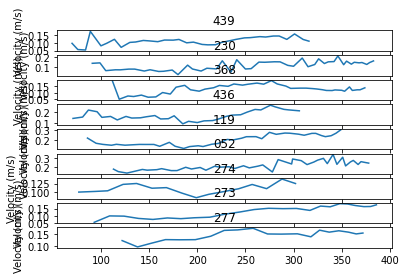

In [55]:
n_subplots = len(white_drifters_60_df) + len(white_drifters_surface_df) + len(yellow_drifters_df)
fig, axs = plt.subplots(n_subplots, sharex=True)
i = 0
for key, df in white_drifters_60_df.items():
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Plot the velocity data
    axs[i].plot(velocities)
    # Set the title to the device id
    axs[i].set_title(key)
    # Set the y-axis label to "Velocity (m/s)"
    axs[i].set_ylabel("Velocity (m/s)")
    i += 1

for key, df in white_drifters_surface_df.items():
    velocities = df['velocity'][1:]
    axs[i].plot(velocities)
    axs[i].set_title(key)
    axs[i].set_ylabel("Velocity (m/s)")
    i += 1

for key, df in yellow_drifters_df.items():
    velocities = df['velocity'][1:]
    axs[i].plot(velocities)
    axs[i].set_title(key)
    axs[i].set_ylabel("Velocity (m/s)")
    i += 1
plt.show()


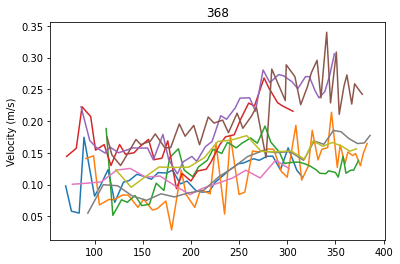

In [56]:
import matplotlib.pyplot as plt

#Create a new figure
plt.figure()

#Iterate through the devices
for key, df in white_drifters_60_df.items():
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Plot the velocity data
    plt.plot(velocities)
    # Set the title to the device id
    plt.title(key)
    # Set the y-axis label to "Velocity (m/s)"
    plt.ylabel("Velocity (m/s)")

for key, df in white_drifters_surface_df.items():
    velocities = df['velocity'][1:]
    plt.plot(velocities)

for key, df in yellow_drifters_df.items():
    velocities = df['velocity'][1:]
    plt.plot(velocities)

#Show the plot
plt.show()

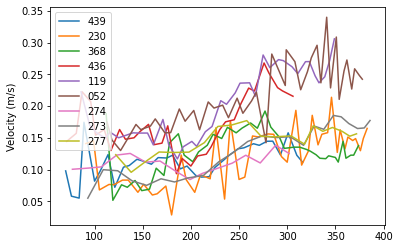

In [57]:
#Create a new figure
plt.figure()

#Iterate through the devices
for key, df in white_drifters_60_df.items():
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Plot the velocity data
    plt.plot(velocities, label=key)
    # Set the title to the device id
    #plt.title(key)
    # Set the y-axis label to "Velocity (m/s)"
    plt.ylabel("Velocity (m/s)")

for key, df in white_drifters_surface_df.items():
    velocities = df['velocity'][1:]
    plt.plot(velocities, label=key)

for key, df in yellow_drifters_df.items():
    velocities = df['velocity'][1:]
    plt.plot(velocities, label=key)

#Show the plot
plt.legend()
plt.show()

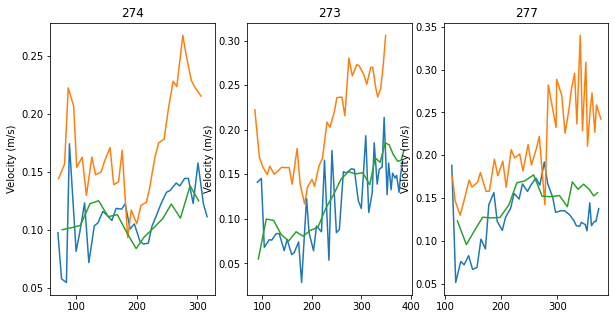

In [58]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Iterate through the devices in white_drifters_60_df
for i, (key, df) in enumerate(white_drifters_60_df.items()):
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Plot the velocity data in the corresponding subplot
    ax[i].plot(velocities)
    # Set the title to the device id
    ax[i].set_title(key)
    # Set the y-axis label to "Velocity (m/s)"
    ax[i].set_ylabel("Velocity (m/s)")

# Iterate through the devices in white_drifters_surface_df
for i, (key, df) in enumerate(white_drifters_surface_df.items()):
    velocities = df['velocity'][1:]
    ax[i].plot(velocities)
    ax[i].set_title(key)
    ax[i].set_ylabel("Velocity (m/s)")

# Iterate through the devices in yellow_drifters_df
for i, (key, df) in enumerate(yellow_drifters_df.items()):
    velocities = df['velocity'][1:]
    ax[i].plot(velocities)
    ax[i].set_title(key)
    ax[i].set_ylabel("Velocity (m/s)")

# Show the plot
plt.show()


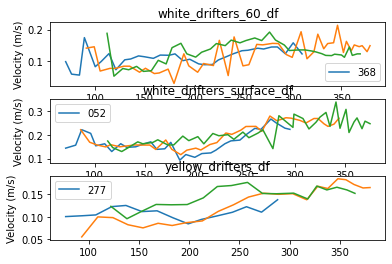

In [59]:
import matplotlib.pyplot as plt

# Create a figure with 3 rows and 1 column
fig, axs = plt.subplots(3, 1)

# Iterate through the devices
for i, (key, df) in enumerate(white_drifters_60_df.items()):
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Plot the velocity data
    axs[0].plot(velocities[:len(velocities)-1])
    # Set the title to the device id
    axs[0].set_title("white_drifters_60_df")
    axs[0].set_ylabel("Velocity (m/s)")
    axs[0].legend([key])

for i, (key, df) in enumerate(white_drifters_surface_df.items()):
    velocities = df['velocity'][1:]
    axs[1].plot(velocities[:len(velocities)-1])
    axs[1].set_title("white_drifters_surface_df")
    axs[1].set_ylabel("Velocity (m/s)")
    axs[1].legend([key])

for i, (key, df) in enumerate(yellow_drifters_df.items()):
    velocities = df['velocity'][1:]
    axs[2].plot(velocities[:len(velocities)-1])
    axs[2].set_title("yellow_drifters_df")
    axs[2].set_ylabel("Velocity (m/s)")
    axs[2].legend([key])

# Show the plots
plt.show()


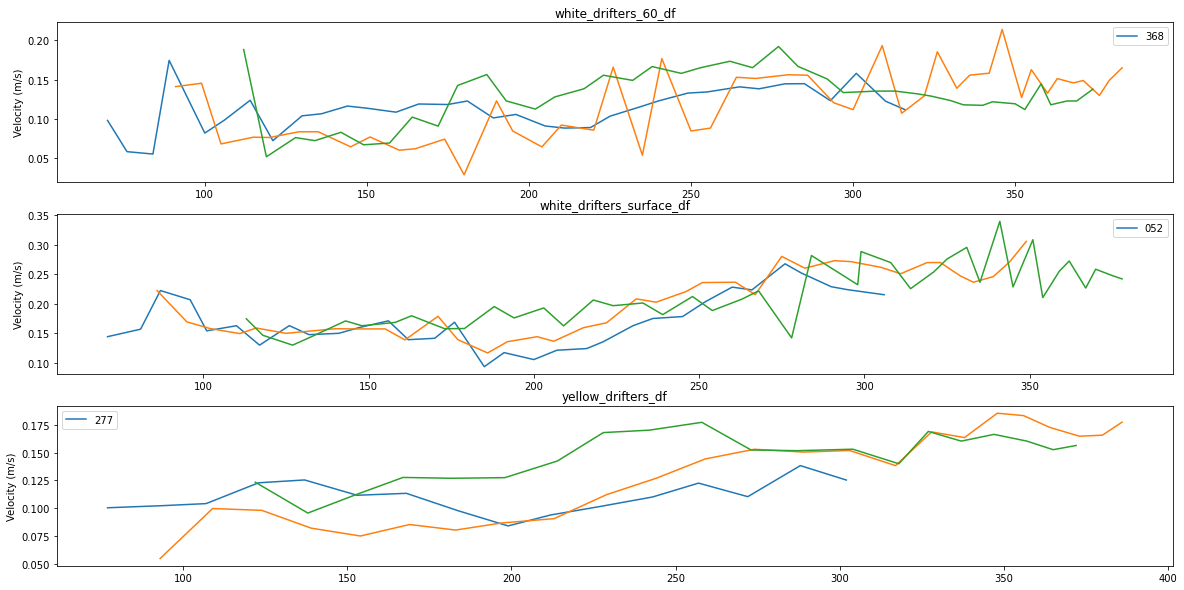

In [60]:
import matplotlib.pyplot as plt

# Create a figure with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(20, 10))

# Iterate through the devices
for i, (key, df) in enumerate(white_drifters_60_df.items()):
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Plot the velocity data
    axs[0].plot(velocities)
    # Set the title to the device id
    axs[0].set_title("white_drifters_60_df")
    axs[0].set_ylabel("Velocity (m/s)")
    axs[0].legend([key])

for i, (key, df) in enumerate(white_drifters_surface_df.items()):
    velocities = df['velocity'][1:]
    axs[1].plot(velocities)
    axs[1].set_title("white_drifters_surface_df")
    axs[1].set_ylabel("Velocity (m/s)")
    axs[1].legend([key])

for i, (key, df) in enumerate(yellow_drifters_df.items()):
    velocities = df['velocity'][1:]
    axs[2].plot(velocities)
    axs[2].set_title("yellow_drifters_df")
    axs[2].set_ylabel("Velocity (m/s)")
    axs[2].legend([key])

# Show the plots
plt.show()


In [62]:

for i, (key, df) in enumerate(white_drifters_surface_df.items()):
    velocities = df['velocity'][1:]
    axs[1].plot(range(len(velocities)), velocities)
    axs[1].set_title("white_drifters_surface_df")
    axs[1].set_ylabel("Velocity (m/s)")
    #axs[1].legend([key])

#Show the plots
plt.show()

In [63]:
for i, (key, df) in enumerate(yellow_drifters_df.items()):
    velocities = df['velocity'][1:]
    axs[2].plot(range(len(velocities)), velocities)
    axs[2].set_title("yellow_drifters_df")
    axs[2].set_ylabel("Velocity (m/s)")
    #axs[2].legend([key])
#Show the plots
plt.show()

In [64]:
import matplotlib.pyplot as plt

for i, (key, df) in enumerate(yellow_drifters_df.items()):
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Plot the velocity data in the i-th subplot
    axs[i].plot(velocities)
    # Set the title to the device id
    axs[i].set_title(key)
    # Set the y-axis label to "Velocity (m/s)"
    axs[i].set_ylabel("Velocity (m/s)")
for i, (key, df) in enumerate(white_drifters_60_df.items()):
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Plot the velocity data in the i-th subplot
    axs[i].plot(velocities)
    # Set the title to the device id
    axs[i].set_title(key)
    # Set the y-axis label to "Velocity (m/s)"
    axs[i].set_ylabel("Velocity (m/s)")
for i, (key, df) in enumerate(white_drifters_surface_df.items()):
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Plot the velocity data in the i-th subplot
    axs[i].plot(velocities)
    # Set the title to the device id
    axs[i].set_title(key)
    # Set the y-axis label to "Velocity (m/s)"
    axs[i].set_ylabel("Velocity (m/s)")
plt.show()

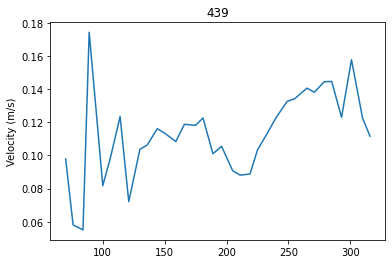

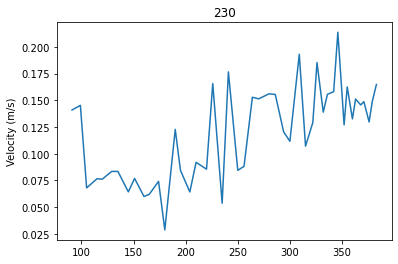

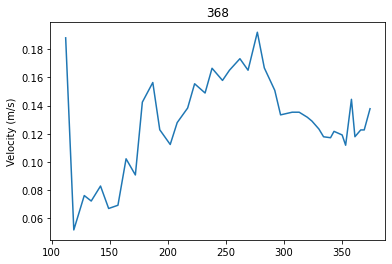

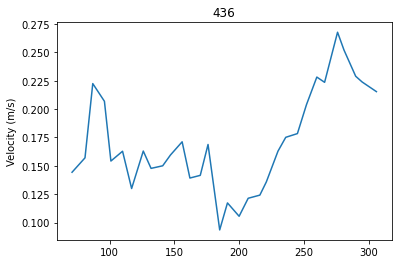

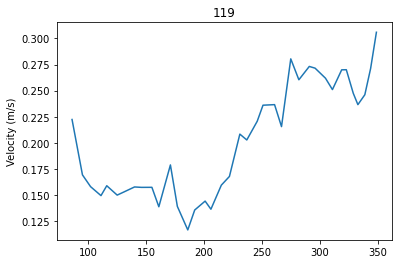

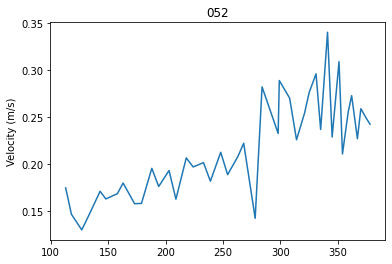

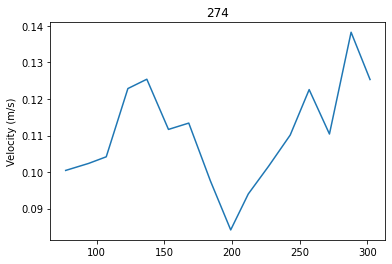

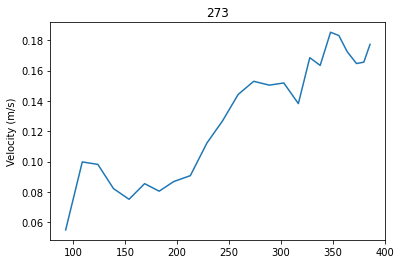

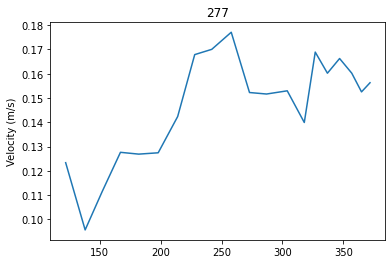

In [65]:
import matplotlib.pyplot as plt

# Iterate through the devices
for key, df in white_drifters_60_df.items():
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Create a new figure
    plt.figure()
    # Plot the velocity data
    plt.plot(velocities)
    # Set the title to the device id
    plt.title(key)
    # Set the y-axis label to "Velocity (m/s)"
    plt.ylabel("Velocity (m/s)")

for key, df in white_drifters_surface_df.items():
    velocities = df['velocity'][1:]
    plt.figure()
    plt.plot(velocities)
    plt.title(key)
    plt.ylabel("Velocity (m/s)")

for key, df in yellow_drifters_df.items():
    velocities = df['velocity'][1:]
    plt.figure()
    plt.plot(velocities)
    plt.title(key)
    plt.ylabel("Velocity (m/s)")

# Show all the plots
plt.show()


In [66]:
#To save the map as html
m.save('drifters_day_2.html')

## CTD Analysis

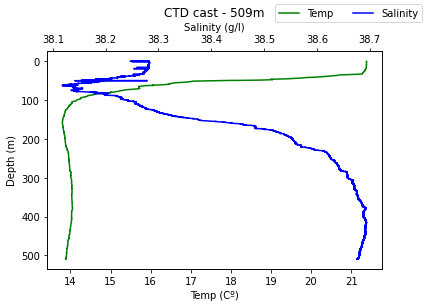

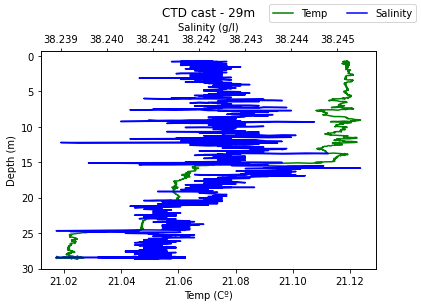

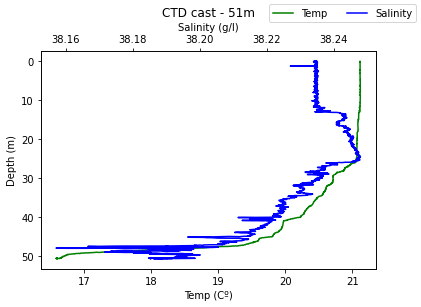

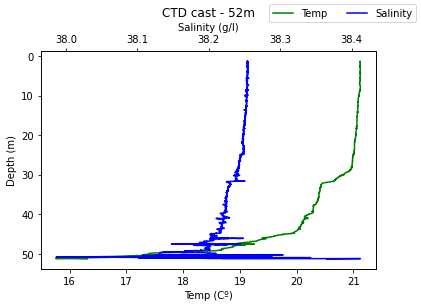

In [67]:
# CTD
parent_dir = 'MIR_BOAT_DAY1_DATA/MIROceanographyAnalysis/CTDData/'
files_list = os.listdir(parent_dir)

#We loop trough the files in the directory
for file in files_list:
    #We select only the cnv files 
    if file[-3:]=='cnv':
        # we get the file name and we open it using ctd module
        fname = os.path.join(parent_dir, file)
        down, up = ctd.from_cnv(fname).split()

        #We plot the data recorded going down
        y = down.index.to_list()
        #We get the tempeture and salinity
        x1 = down['t090C'].to_list()
        x2 = down['sal00'].to_list()
        #Create the figure
        fig, ax1 = plt.subplots()
        ax2 = ax1.twiny()
        ax1.plot(x1, y, 'g-', label="Temp")
        ax1.set_xlabel("Temp (Cº)")
        ax1.set_ylabel("Depth (m)")
        ax2.plot(x2, y, 'b-', label="Salinity")
        ax2.set_xlabel("Salinity (g/l)")
        plt.gca().invert_yaxis()
        plt.title(f"CTD cast - {int(np.ceil(max(y)))}m")

        fig.legend(['Temp', 'Salinity'], loc = 1, ncol=2)

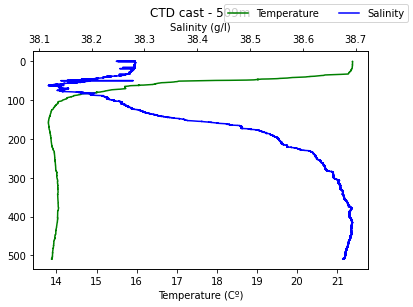

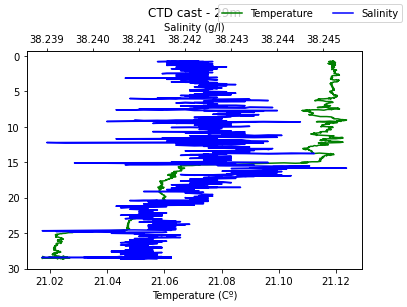

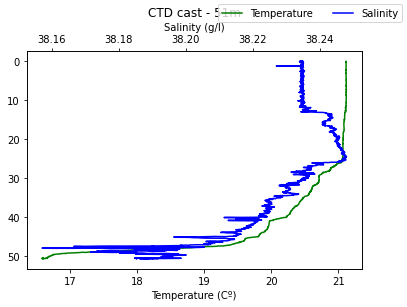

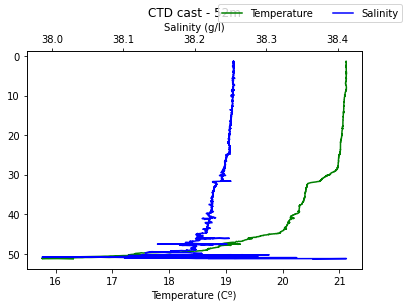

In [68]:
# CTD
parent_dir = 'MIR_BOAT_DAY1_DATA/MIROceanographyAnalysis/CTDData/'
files_list = os.listdir(parent_dir)

# We loop through the files in the directory
for file in files_list:
    # We select only the cnv files 
    if file[-3:] == 'cnv':
        # We get the file name and we open it using ctd module
        fname = os.path.join(parent_dir, file)
        down, up = ctd.from_cnv(fname).split()

        # We plot the data recorded going down
        y = down.index.to_list()
        # We get the temperature, salinity, and density data
        x1 = down['t090C'].to_list()
        x2 = down['sal00'].to_list()
        # x3 = down['sigma-t'].to_list()
        # Create the figure
        fig, ax1 = plt.subplots()
        ax2 = ax1.twiny()
        # ax3 = ax1.twinx()
        ax1.plot(x1, y, 'g-', label="Temperature")
        ax1.set_xlabel("Temperature (Cº)")
        ax2.plot(x2, y, 'b-', label="Salinity")
        ax2.set_xlabel("Salinity (g/l)")
        # ax3.plot(x3, y, 'r-', label="Density")
        # ax3.set_ylabel("Depth (m)")
        plt.gca().invert_yaxis()
        plt.title(f"CTD cast - {int(np.ceil(max(y)))}m")

        fig.legend(['Temperature', 'Salinity'], loc=1, ncol=3)


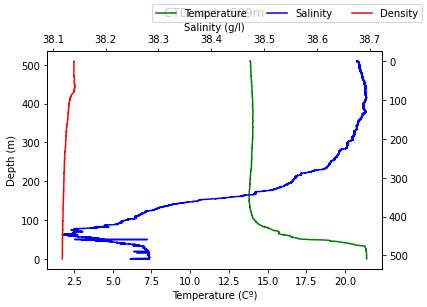

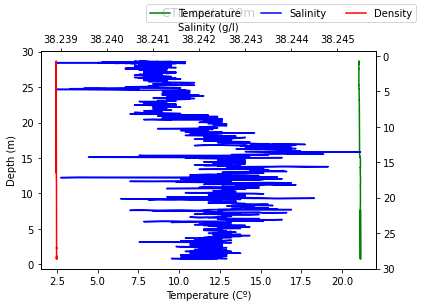

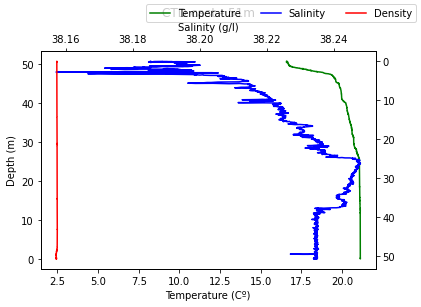

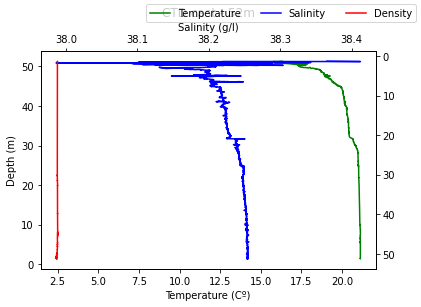

In [69]:
# CTD
parent_dir = 'MIR_BOAT_DAY1_DATA/MIROceanographyAnalysis/CTDData/'
files_list = os.listdir(parent_dir)

# We loop through the files in the directory
for file in files_list:
    # We select only the cnv files 
    if file[-3:]=='cnv':
        # we get the file name and we open it using ctd module
        fname = os.path.join(parent_dir, file)
        down, up = ctd.from_cnv(fname).split()

        # We plot the data recorded going down
        y = down.index.to_list()
        # We get the temperature, salinity, and density data
        x1 = down['t090C'].to_list()
        x2 = down['sal00'].to_list()
        x3 = down['sbeox0V'].to_list()
        # Create the figure
        fig, ax1 = plt.subplots()
        ax2 = ax1.twiny()
        ax3 = ax1.twinx()
        ax1.plot(x1, y, 'g-', label="Temperature")
        ax1.set_xlabel("Temperature (Cº)")
        ax1.set_ylabel("Depth (m)")
        ax2.plot(x2, y, 'b-', label="Salinity")
        ax2.set_xlabel("Salinity (g/l)")
        ax3.plot(x3, y, 'r-', label="Density")
        ax3.set_xlabel("Density (kg/m^3)")
        plt.gca().invert_yaxis()
        plt.title(f"CTD cast - {int(np.ceil(max(y)))}m")

        fig.legend(['Temperature', 'Salinity', 'Density'], loc = 1, ncol=3)


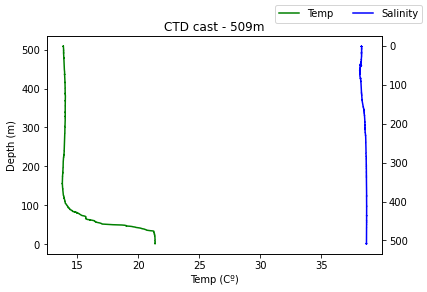

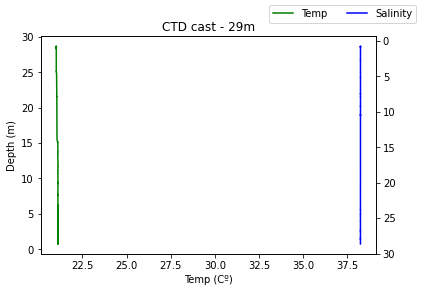

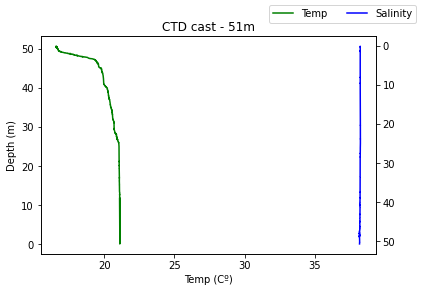

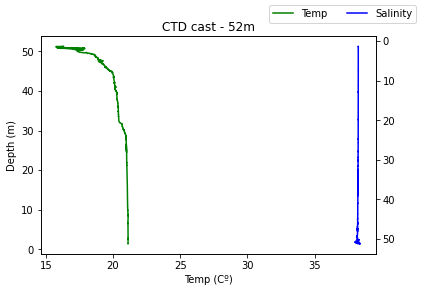

In [70]:
# CTD
parent_dir = 'MIR_BOAT_DAY1_DATA/MIROceanographyAnalysis/CTDData/'
files_list = os.listdir(parent_dir)

#We loop trough the files in the directory
for file in files_list:
    #We select only the cnv files 
    if file[-3:]=='cnv':
        # we get the file name and we open it using ctd module
        fname = os.path.join(parent_dir, file)
        down, up = ctd.from_cnv(fname).split()

        #We plot the data recorded going down
        y = down.index.to_list()
        #We get the tempeture and salinity
        x1 = down['t090C'].to_list()
        x2 = down['sal00'].to_list()
        #Create the figure
        fig, ax1 = plt.subplots()
        # Create a second y-axis and plot the salinity data on it
        ax2 = ax1.twinx()
        ax1.plot(x1, y, 'g-', label="Temp")
        ax1.set_xlabel("Temp (Cº)")
        ax1.set_ylabel("Depth (m)")
        ax2.plot(x2, y, 'b-', label="Salinity")
        ax2.set_xlabel("Salinity (g/l)")
        plt.gca().invert_yaxis()
        plt.title(f"CTD cast - {int(np.ceil(max(y)))}m")

        # Add a legend to the figure
        fig.legend(['Temp', 'Salinity'], loc = 1, ncol=2)


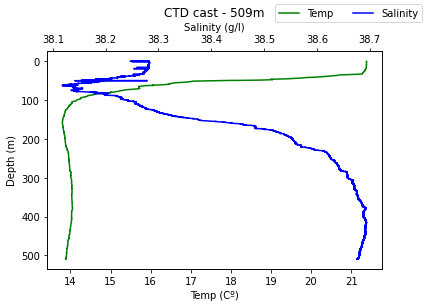

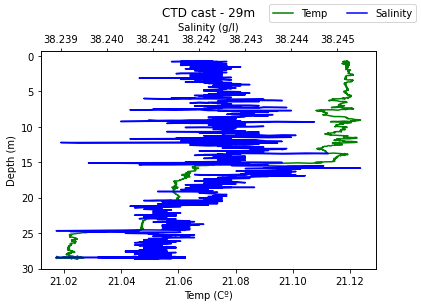

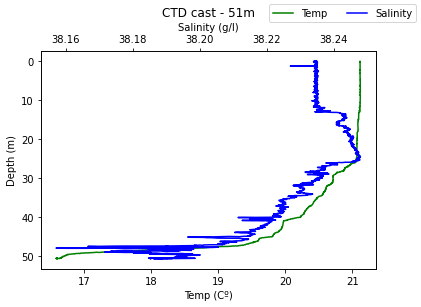

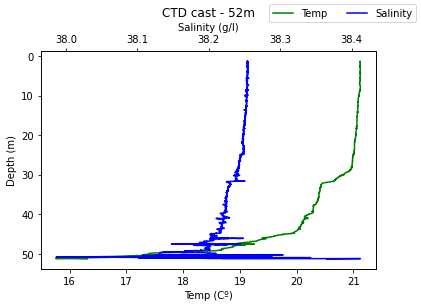

In [71]:
import matplotlib.pyplot as plt
import ctd
import os

# CTD
parent_dir = 'MIR_BOAT_DAY1_DATA/MIROceanographyAnalysis/CTDData/'
files_list = os.listdir(parent_dir)

#We loop trough the files in the directory
for file in files_list:
    #We select only the cnv files 
    if file[-3:]=='cnv':
        # we get the file name and we open it using ctd module
        fname = os.path.join(parent_dir, file)
        down, up = ctd.from_cnv(fname).split()

        #We plot the data recorded going down
        y = down.index.to_list()
        #We get the temperature and salinity
        x1 = down['t090C'].to_list()
        x2 = down['sal00'].to_list()
        #Create the figure
        fig, ax1 = plt.subplots()
        ax2 = ax1.twiny()
        ax1.plot(x1, y, 'g-', label="Temp")
        ax1.set_xlabel("Temp (Cº)")
        ax1.set_ylabel("Depth (m)")
        ax2.plot(x2, y, 'b-', label="Salinity")
        ax2.set_xlabel("Salinity (g/l)")
        plt.gca().invert_yaxis()
        plt.title(f"CTD cast - {int(np.ceil(max(y)))}m")

        fig.legend(['Temp', 'Salinity'], loc = 1, ncol=2)


In [72]:
import netCDF4

# Open the NetCDF file
nc_file = netCDF4.Dataset("/content/12102021_00382_.nc", "r")

# Print some information about the file
print("Dimensions:", nc_file.dimensions.keys())
print("Variables:", nc_file.variables.keys())



# Close the file when you're done
nc_file.close()


FileNotFoundError: ignored